# Setup

In [1]:
# Add parent directory to current path. Needed for research imports.
import os.path
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)

# Enable hot reloading
%load_ext autoreload
%autoreload 2


import datetime
import itertools
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from experiments.irl.fair_irl import *
from research.irl.fair_irl import *
from research.ml.svm import SVM
from research.utils import *
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold


logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

cp = sns.color_palette()
sns.set_style('darkgrid')

from IPython.display import display, HTML
display(HTML("<style>.container { width:1800px !important; }</style>"))
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

# Run trial

### Define method

In [140]:
def run_exp_trials(trial_info):
    logging.info(f"trial_info: {trial_info}")
    
    # Initiate objectives
    obj_lookup_by_name = {
        'Acc': AccuracyObjective,
        'DemPar': DemographicParityObjective,
        'EqOpp': EqualOpportunityObjective,
        'PredPar': PredictiveEqualityObjective,
    }
    objectives = []
    for obj_name in trial_info['OBJECTIVE_NAMES']:
        objectives.append(obj_lookup_by_name[obj_name]())
    obj_set = ObjectiveSet(objectives)
    del objectives
    
    ##
    # Run the experiment trials
    ##
    results = []
    trial_i = 0
    while trial_i < trial_info['N_TRIALS']:

        if 'FO' in trial_info['IRL_METHOD']:
            CAN_OBSERVE_Y = True
        else:
            CAN_OBSERVE_Y = False

        logging.info(f"\n\nTRIAL {trial_i}\n")
        ##
        # Reset the objective set since they get fitted in each trial run
        ##
        obj_set.reset()

        ##
        # Read in dataset
        ##
        X, y, feature_types = generate_dataset(trial_info['DATASET'], n_samples=trial_info['N_DATASET_SAMPLES'])

        # These are the feature types that will be used in the classifier that will
        # predict `y` given `X` when learning the optimal policy for a given reward
        # function.
        expert_demo_feature_types = feature_types
        irl_loop_feature_types = feature_types

        pipe = sklearn_clf_pipeline(
            feature_types=expert_demo_feature_types,
        #     clf_inst=RandomForestClassifier(),  # For some resaon, using a RF here prevents the ThresholdOptimizer from obtaining a decent value on Demographic Parity
            clf_inst=DecisionTreeClassifier(min_samples_leaf=10, max_depth=4),
        )
        dem_par_clf = ThresholdOptimizer(
            estimator=pipe,
            constraints='demographic_parity',
    #         objective='selection_rate',
            predict_method="predict",
            prefit=False,
        )
        dem_par_reduction = ReductionWrapper(
            clf=dem_par_clf,
            sensitive_features='z',
        )
        pipe = sklearn_clf_pipeline(
            feature_types=expert_demo_feature_types,
#             clf_inst=RandomForestClassifier(),  # For some resaon, using a RF here prevents the ThresholdOptimizer from obtaining a decent value on Demographic Parity
            clf_inst=DecisionTreeClassifier(min_samples_leaf=10, max_depth=4),
        )
        eq_opp_clf = ThresholdOptimizer(
            estimator=pipe,
            constraints='true_positive_rate_parity',
            predict_method="predict",
            prefit=False,
        )
        eq_opp_reduction = ReductionWrapper(
            clf=eq_opp_clf,
            sensitive_features='z',
        )
        pred_eq_clf = ThresholdOptimizer(
            estimator=pipe,
            constraints='false_negative_rate_parity',
            predict_method="predict",
            prefit=False,
        )
        pred_eq_reduction = ReductionWrapper(
            clf=pred_eq_clf,
            sensitive_features='z',
        )

        EXPERT_ALGO_LOOKUP = {
            'OptAcc': sklearn_clf_pipeline(expert_demo_feature_types, RandomForestClassifier()),
            'OptAccDecTree': sklearn_clf_pipeline(expert_demo_feature_types, clf_inst=DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)),
            # 'pos_pred_to_female_only': ManualClassifier(lambda row: int(row['sex'] == 'Female')),
            'HardtDemPar': dem_par_reduction,
            'HardtEqOpp': eq_opp_reduction,
            'PredEq': pred_eq_reduction,
        }

        ##
        # Split data into 3 sets.
        #     1. Demo - Produces expert demonstratinos
        #         1A. Train – Used for predicting Y from Z,X
        #         1B. Test – used for comparing muL with muE
        #     2. Hold – computes the unbiased values for muL and t (dataset is
        #.       never shown to the IRL learning algo.)
        ##
        X_demo, X_hold, y_demo, y_hold = train_test_split(X, y, test_size=.2)
        X_train, X_test, y_train, y_test = train_test_split(X_demo, y_demo, test_size=.5)
        del X_demo, y_demo # Make sure I don't acidentally use these variables later on

        ##
        # Generate expert demonstrations to learn from
        ##
        muE, demosE = generate_demos_k_folds(
            X=X_test,
            y=y_test,
            clf=EXPERT_ALGO_LOOKUP[trial_info['EXPERT_ALGO']],
            obj_set=obj_set,
            n_demos=trial_info['N_EXPERT_DEMOS'],
        )
        logging.info(f"muE:\n{muE}")

        ##
        # Generate expert demonstrations to learn for computing learned
        # performance. These expert demos are never shown to the IRL algo and are
        # only used for performance measurement.
        ##
        muE_hold, demosE_hold = generate_demos_k_folds(
            X=X_hold,
            y=y_hold,
            clf=EXPERT_ALGO_LOOKUP[trial_info['EXPERT_ALGO']],
            obj_set=obj_set,
            n_demos=trial_info['N_EXPERT_DEMOS'],
        )
        logging.info(f"muE_hold:\n{muE_hold}")

        ##
        # Run IRL loop.
        # Create a clf dataset where inputs are feature expectations and outputs are
        # whether the policy is expert or learned through IRL iterations. Then train
        # an SVM classifier on this dataset. Then extract the weights of the svm and
        # use them as the weights for the "reward" function. Then use this reward
        # function to learn a policy (classifier). Then compute the feature
        # expectations from this classifer on the irl hold-out set. Then compute the
        # error between the feature expectations of this learned clf and the
        # demonstration feature exp. If this error is less than epsilon, stop. The
        # reward function is the final set of weights.
        ##

        x_cols = (
            irl_loop_feature_types['boolean']
            + irl_loop_feature_types['categoric']
            + irl_loop_feature_types['continuous']
        )
        x_cols.remove('z')
        obj_set_cols = [obj.name for obj in obj_set.objectives]


        # Generate initial learned policies
        mu, _demos = generate_demos_k_folds(
            X=X_train,
            y=y_train,
            clf=DummyClassifier(strategy="uniform"),
            obj_set=obj_set,
            n_demos=trial_info['N_INIT_POLICIES'],
        )

        X_irl_exp = pd.DataFrame(muE, columns=obj_set_cols)
        y_irl_exp = pd.Series(np.ones(trial_info['N_EXPERT_DEMOS']), dtype=int)
        X_irl_learn = pd.DataFrame(mu, columns=obj_set_cols)
        y_irl_learn = pd.Series(np.zeros(len(mu)), dtype=int)

        t = []  # Errors for each iteration
        t_hold = []  # Errors on hold out set for each iteration
        mu_delta_l2norm_hist = []
        mu_delta_l2norm_hold_hist = []
        weights = []
        i = 0
        demo_history = []
        demo_hold_history = []
        mu_history = []
        mu_hold_history = []
        mu_best_history = []
        mu_best_hold_history = []

        logging.debug('')
        logging.debug('Starting IRL Loop ...')

        while True:
            logging.info(f"\tIRL Loop iteration {i+1}/{trial_info['MAX_ITER']} ...")

            # Train SVM classifier that distinguishes which demonstrations are expert
            # and which were generated from this loop.
            logging.debug('\tFitting SVM classifier...')
            X_irl = pd.concat([X_irl_exp, X_irl_learn], axis=0).reset_index(drop=True)
            y_irl = pd.concat([y_irl_exp, y_irl_learn], axis=0).reset_index(drop=True)
            svm = SVM().fit(X_irl, y_irl)
            wi = svm.weights()
            weights.append(wi)

            ##
            # Learn a policy (clf_pol) from the reward (SVM) weights.
            ##

            # Fit a classifier that predicts `y` from `X`.
            logging.debug('\tFitting `y|x` predictor for clf policy...')
            clf = sklearn_clf_pipeline(
                feature_types=irl_loop_feature_types,
                clf_inst=RandomForestClassifier(),
            )
            clf.fit(X_train, y_train)

            # Learn a policy that maximizes the reward function.
            logging.debug('\tComputing the optimal policy given reward weights and `y|x` classifier...')
            reward_weights = { obj.name: wi[j] for j, obj in enumerate(obj_set.objectives) }
            test_df = pd.DataFrame(X_test)
            test_df['y'] = y_test
            clf_pol = compute_optimal_policy(
                clf_df=test_df,  # NOT the dataset used to train the C_{Y_Z,X} clf
                clf=clf,
                x_cols=x_cols,
                obj_set=obj_set,
                reward_weights=reward_weights,
                skip_error_terms=True,
                method=trial_info['METHOD'],
            )

            # Compute feature expectations of the learned policy
            logging.debug('\tGenerating learned demostration...')
            demo = generate_demo(clf_pol, X_test, y_test, can_observe_y=CAN_OBSERVE_Y)
            demo_hold = generate_demo(clf_pol, X_hold, y_hold, can_observe_y=False)
            demo_history.append(demo)
            demo_hold_history.append(demo_hold)
            muj = obj_set.compute_demo_feature_exp(demo)
            muj_hold = obj_set.compute_demo_feature_exp(demo_hold)
            mu_history.append(muj)
            mu_hold_history.append(muj_hold)
            logging.debug(f"\t\t muL[i] = {np.round(muj, 3)}")
            logging.debug(f"\t\t muL_hold[i] = {np.round(muj_hold, 3)}")

            # Append policy's feature expectations to irl clf dataset
            X_irl_learn_i = pd.DataFrame(np.array([muj]), columns=obj_set_cols)
            y_irl_learn_i = pd.Series(np.zeros(1), dtype=int)
            X_irl_learn = pd.concat([X_irl_learn, X_irl_learn_i], axis=0)
            y_irl_learn = pd.concat([y_irl_learn, y_irl_learn_i], axis=0)

            # Compute error of the learned policy: t[i] = wT(muE-mu[j])
            ti, best_j, mu_delta, mu_delta_l2norm = irl_error(wi, muE, mu_history)
            ti_hold, best_j_hold, mu_delta_hold, mu_delta_l2norm_hold = irl_error(wi, muE_hold, mu_hold_history)
            mu_best_history.append(mu_history[best_j])
            mu_best_hold_history.append(mu_hold_history[best_j])
            t.append(ti)
            t_hold.append(ti_hold)
            mu_delta_l2norm_hist.append(mu_delta_l2norm)
            mu_delta_l2norm_hold_hist.append(mu_delta_l2norm_hold)
            logging.debug(f"\t\t mu_delta[i] \t= {np.round(mu_delta, 3)}")
            logging.debug(f"\t\t mu_delta_hold[i] \t= {np.round(mu_delta_hold, 3)}")
            logging.debug(f"\t\t t[i] \t\t= {t[i]:.5f}")
            logging.debug(f"\t\t t_hold[i] \t\t= {t_hold[i]:.5f}")
            logging.debug(f"\t\t weights[{i}] \t= {np.round(weights[i], 3)}")

            ## Show a summary of the learned policy
            # logging.info(
            #     df_to_log(
            #         demo.groupby(['z']+x_cols+['y', 'yhat'])[['age']].agg(['count']),
            #         title='\tLearned Policy:',
            #         tab_level=3,
            #     )
            # )

            if ti < trial_info['EPSILON'] or i >= trial_info['MAX_ITER'] - 1:
                break

            i += 1

            # End IRL Loop

        ##
        # Book keeping
        ##

        # Compare the best learned policy with the expert demonstrations
        best_t = np.min(t)
        best_iter = None
        for t_i, _t in enumerate(t):
            if np.allclose(best_t, _t, atol=.0001):
                best_iter = t_i
                break

        best_demo = demo_history[best_iter]
        best_weight = weights[best_iter]
        logging.debug('Best iteration: ' + str(best_iter))
        logging.info(f"Best Learned Policy yhat: {best_demo['yhat'].mean():.3f}")
        logging.info(f"best weight:\t {np.round(best_weight, 3)}")

        # Generate a dataframe for results gathering.
        X_irl = pd.concat([X_irl_exp, X_irl_learn], axis=0).reset_index(drop=True)
        y_irl = pd.concat([y_irl_exp, y_irl_learn], axis=0).reset_index(drop=True)
        df_irl = X_irl.copy()
        df_irl['is_expert'] = y_irl.copy()
        for i, col in enumerate(obj_set_cols):
            df_irl[f"muL_best_{col}"] = np.zeros(trial_info['N_EXPERT_DEMOS']+trial_info['N_INIT_POLICIES']).tolist() + np.array(mu_best_history)[:, i].tolist()
            df_irl[f"muL_hold_{col}"] = np.zeros(trial_info['N_EXPERT_DEMOS']+trial_info['N_INIT_POLICIES']).tolist() + np.array(mu_hold_history)[:, i].tolist()
            df_irl[f"muL_best_hold_{col}"] = np.zeros(trial_info['N_EXPERT_DEMOS']+trial_info['N_INIT_POLICIES']).tolist() + np.array(mu_best_hold_history)[:, i].tolist()
        df_irl['is_init_policy'] = np.zeros(trial_info['N_EXPERT_DEMOS']).tolist() + np.ones(trial_info['N_INIT_POLICIES']).tolist() + np.zeros(len(t)).tolist()
        df_irl['learn_idx'] = list(-1*np.ones(trial_info['N_EXPERT_DEMOS'])) + list(np.arange(trial_info['N_INIT_POLICIES'] + len(t)))
        for i, col in enumerate(obj_set_cols):
            df_irl[f"{col}_weight"] = np.zeros(trial_info['N_EXPERT_DEMOS']+trial_info['N_INIT_POLICIES']).tolist() + [w[i] for w in weights]
        df_irl['t'] = list(np.inf*(np.ones(trial_info['N_EXPERT_DEMOS']+trial_info['N_INIT_POLICIES']))) + t
        df_irl['t_hold'] = list(np.inf*(np.ones(trial_info['N_EXPERT_DEMOS']+trial_info['N_INIT_POLICIES']))) + t_hold
        df_irl['mu_delta_l2norm'] = np.zeros(trial_info['N_EXPERT_DEMOS']+trial_info['N_INIT_POLICIES']).tolist() + mu_delta_l2norm_hist
        df_irl['mu_delta_l2norm_hold'] = np.zeros(trial_info['N_EXPERT_DEMOS']+trial_info['N_INIT_POLICIES']).tolist() + mu_delta_l2norm_hold_hist
        logging.debug('Experiment Summary')
        display(df_irl.round(3))

    #     ##
    #     # Plot results
    #     ##
    #     sns.set_theme(style='darkgrid', font_scale=1.2)
    #     feat_exp_combs = list(itertools.combinations(obj_set_cols, 2))
    #     exp = df_irl.query('is_expert == True').reset_index(drop=True)
    #     lrn = df_irl.query('is_expert == False').reset_index(drop=True)
    #     best_t_idx = lrn.query('t > 0')['t'].argmin()
    #     fig, axes = plt.subplots(1, len(feat_exp_combs), figsize=(5*len(feat_exp_combs), 4))
    #     axes = (axes,) if len(feat_exp_combs) == 1 else axes
    #     for i, (feat_exp_x, feat_exp_y) in enumerate(feat_exp_combs):
    #         # Plot expert
    #         axes[i].scatter(exp[feat_exp_x], exp[feat_exp_y], label='$\mu^E$', s=600, alpha=1, c='black')
    #         # Inject noise so we can see the expert when it's overlapping
    #         noise = trial_info['NOISE_FACTOR']*(np.random.rand(len(lrn))-.6)
    #         # Plot the learned policies
    #         axes[i].scatter(lrn[feat_exp_x]+noise, lrn[feat_exp_y]+noise, label='$\mu^L_i$', s=600, alpha=.7, c=cp[2])
    #         axes[i].set_ylim([-.1, 1.1])
    #         axes[i].set_xlim([-.1, 1.1])
    #         axes[i].set_xlabel(feat_exp_x.replace('_', ' ').title())
    #         axes[i].set_ylabel(feat_exp_y.replace('_', ' ').title())
    #         if trial_info['ANNOTATE']:
    #             # Label each learned policy with its ordered index
    #             for idx, row in lrn.iterrows():
    #                 if row['is_init_policy']:
    #                     annotation = None
    #                 else:
    #                     annotation = idx
    #                 axes[i].annotate(annotation, (-.012+(row[feat_exp_x]+noise[idx]), -.015+(row[feat_exp_y]+noise[idx])), fontsize=16, fontweight=700)
    #         # Color the best policy
    #         axes[i].scatter([lrn.loc[best_t_idx][feat_exp_x]+noise[best_t_idx]], [lrn.loc[best_t_idx][feat_exp_y]+noise[best_t_idx]], label='Best $\mu^L_i$', s=600, alpha=1, c=cp[1])
    #         axes[i].legend(ncol=1, labelspacing=.7, loc='upper left')

    #     plt.suptitle(f"Best learned weights: {best_weight.round(2)}")
    #     plt.tight_layout()

        # End regular IRL trial

        ##############################################################################
        # Learn policy in new domain
        ##############################################################################

        muE_target = None
        muL_target_hold = None

        if trial_info['TARGET_DATASET'] is not None:

            obj_set.reset()

            # Get the best weights from the source domain
            source_best_w = np.zeros(len(obj_set_cols))
            for i, o in enumerate(obj_set_cols):
                best_idx = np.argmin(mu_delta_l2norm_hold_hist)
                source_best_w[i] = weights[best_idx][i]
    #             source_best_w[i] = exp_df.loc[exp_df['muL_hold_err_l2norm'].argmin()][w_idx]

            ##
            # Read in target domain dataset
            ##
            X, y, feature_types = generate_dataset(trial_info['TARGET_DATASET'], n_samples=trial_info['N_DATASET_SAMPLES'])

            x_cols = (
                feature_types['boolean']
                + feature_types['categoric']
                + feature_types['continuous']
            )
            x_cols.remove('z')

            expert_demo_feature_types = feature_types
            irl_loop_feature_types = feature_types

            # These are the feature types that will be used in the classifier that will
            # predict `y` given `X` when learning the optimal policy for a given reward
            # function.
            pipe = sklearn_clf_pipeline(
                feature_types=expert_demo_feature_types,
            #     clf_inst=RandomForestClassifier(),  # For some resaon, using a RF here prevents the ThresholdOptimizer from obtaining a decent value on Demographic Parity
                clf_inst=DecisionTreeClassifier(min_samples_leaf=10, max_depth=4),
            )
            dem_par_clf = ThresholdOptimizer(
                estimator=pipe,
                constraints='demographic_parity',
        #         objective='selection_rate',
                predict_method="predict",
                prefit=False,
            )
            dem_par_reduction = ReductionWrapper(
                clf=dem_par_clf,
                sensitive_features='z',
            )
            pipe = sklearn_clf_pipeline(
                feature_types=expert_demo_feature_types,
            #     clf_inst=RandomForestClassifier(),  # For some resaon, using a RF here prevents the ThresholdOptimizer from obtaining a decent value on Demographic Parity
                clf_inst=DecisionTreeClassifier(min_samples_leaf=10, max_depth=4),
            )
            eq_opp_clf = ThresholdOptimizer(
                estimator=pipe,
                constraints='true_positive_rate_parity',
                predict_method="predict",
                prefit=False,
            )
            eq_opp_reduction = ReductionWrapper(
                clf=eq_opp_clf,
                sensitive_features='z',
            )
            pred_eq_clf = ThresholdOptimizer(
                estimator=pipe,
                constraints='false_negative_rate_parity',
                predict_method="predict",
                prefit=False,
            )
            pred_eq_reduction = ReductionWrapper(
                clf=pred_eq_clf,
                sensitive_features='z',
            )

            EXPERT_ALGO_LOOKUP = {
                'OptAcc': sklearn_clf_pipeline(expert_demo_feature_types, RandomForestClassifier()),
                'OptAccDecTree': sklearn_clf_pipeline(expert_demo_feature_types, clf_inst=DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)),
                # 'pos_pred_to_female_only': ManualClassifier(lambda row: int(row['sex'] == 'Female')),
                'HardtDemPar': dem_par_reduction,
                'HardtEqOpp': eq_opp_reduction,
                'PredEq': pred_eq_reduction,
            }

            ##
            # Split data into 3 sets.
            #     1. Demo - Produces expert demonstratinos
            #         1A. Train – Used for predicting Y from Z,X
            #         1B. Test – used for comparing muL with muE
            #     2. Hold – computes the unbiased values for muL and t (dataset is
            #.       never shown to the IRL learning algo.)
            ##
            X_demo, X_hold, y_demo, y_hold = train_test_split(X, y, test_size=.5)
            X_train, X_test, y_train, y_test = train_test_split(X_demo, y_demo, test_size=.5)
            del X_demo, y_demo # Make sure I don't acidentally use these variables later on

            ##
            # Generate expert demonstrations to compare against.
            ##
            muE_target, demosE_target = generate_demos_k_folds(
                X=X_test,
                y=y_test,
                clf=EXPERT_ALGO_LOOKUP[trial_info['EXPERT_ALGO']],
                obj_set=obj_set,
                n_demos=trial_info['N_EXPERT_DEMOS'],
            )
            logging.info(f"muE:\n{muE}")

            ##
            # Learn a policy (clf_pol) from the reward (SVM) weights.
            ##

            # Fit a classifier that predicts `y` from `X`.
            clf = sklearn_clf_pipeline(
                feature_types=feature_types,
                clf_inst=RandomForestClassifier(),
            )
            clf.fit(X_train, y_train)

            # Learn a policy that maximizes the reward function.
            reward_weights = { obj.name: source_best_w[j] for j, obj in enumerate(obj_set.objectives) }
            test_df = pd.DataFrame(X_test)
            test_df['y'] = y_test
            clf_pol = compute_optimal_policy(
                clf_df=test_df,  # NOT the dataset used to train the C_{Y_Z,X} clf
                clf=clf,
                x_cols=x_cols,
                obj_set=obj_set,
                reward_weights=reward_weights,
                skip_error_terms=True,
                method=trial_info['METHOD'],
            )

            # Compute feature expectations of the learned policy
            demo = generate_demo(clf_pol, X_test, y_test, can_observe_y=CAN_OBSERVE_Y)
            demo_hold = generate_demo(clf_pol, X_hold, y_hold, can_observe_y=False)
            # demo_history.append(demo)
            # demo_hold_history.append(demo_hold)
            muL_target = obj_set.compute_demo_feature_exp(demo)
            muL_target_hold = obj_set.compute_demo_feature_exp(demo_hold)
            # mu_history.append(muj)
            # mu_hold_history.append(muj_hold)
            logging.info(f"target domain muL = {np.round(muL_target, 3)}")
            logging.info(f"target domain muE = {np.round(muE_target.mean(axis=0), 3)}")
            logging.info(f"target domain muL_hold = {np.round(muL_target_hold, 3)}")

            ##
            # Aggregate trial results
            ##
            results.append(new_trial_result(
                obj_set,
                muE,
                muE_hold,
                df_irl, muE_target.mean(axis=0), muL_target_hold))

            trial_i += 1

        # End Trial




    ##############################################################################
    # Persist trial results
    ##############################################################################
    exp_df = generate_single_exp_results_df(obj_set, results)
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    exp_df.to_csv(f"./../../data/experiment_output/fair_irl/trial_results/{timestamp}.csv", index=None)

    ##
    # Persist trial info
    ##
    trial_info['timestamp'] = timestamp
    fp = f"./../../data/experiment_output/fair_irl/trial_info/{timestamp}.json"
    json.dump(trial_info, open(fp, 'w'))
    
    return None

### Set parameters and run

In [170]:
base_trial_info = {
    'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'],
    # Expert demo parameters
    'DATASET': None,
    'TARGET_DATASET': None,
    'N_EXPERT_DEMOS': 3,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 25_000,
    # IRL Loop parameters
    'N_TRIALS': 6,
    'IRL_METHOD': None,
    'N_INIT_POLICIES': 1,
    'EPSILON': .03,
    'MAX_ITER': 6,
    'METHOD': 'highs',
    # Plotting parameters
    'NOISE_FACTOR': .02,
    'ANNOTATE': True,
}
 
trials = [
#     {
#         'DATASET': 'Boston',
#         'TARGET_DATASET': 'Adult',
#         'EXPERT_ALGO': 'OptAcc',
#         'IRL_METHOD': 'FairIRL',
#         'N_TRIALS': 20,
#         'N_DATASET_SAMPLES': 506,
#     },
    {
        'DATASET': 'Boston',
        'TARGET_DATASET': 'Adult',
        'EXPERT_ALGO': 'HardtDemPar',
        'IRL_METHOD': 'FairIRL',
        'N_TRIALS': 20,
        'N_DATASET_SAMPLES': 506,
    },
    {
        'DATASET': 'Boston',
        'TARGET_DATASET': 'Adult',
        'EXPERT_ALGO': 'HardtEqOpp',
        'IRL_METHOD': 'FairIRL',
        'N_TRIALS': 20,
        'N_DATASET_SAMPLES': 506,
    },
    {
        'DATASET': 'Boston',
        'TARGET_DATASET': 'Adult',
        'EXPERT_ALGO': 'OptAcc',
        'IRL_METHOD': 'FairIRLFO',
        'N_TRIALS': 20,
        'N_DATASET_SAMPLES': 506,
    },
    {
        'DATASET': 'Boston',
        'TARGET_DATASET': 'Adult',
        'EXPERT_ALGO': 'HardtDemPar',
        'IRL_METHOD': 'FairIRLFO',
        'N_TRIALS': 20,
        'N_DATASET_SAMPLES': 506,
    },
    {
        'DATASET': 'Boston',
        'TARGET_DATASET': 'Adult',
        'EXPERT_ALGO': 'HardtEqOpp',
        'IRL_METHOD': 'FairIRLFO',
        'N_TRIALS': 20,
        'N_DATASET_SAMPLES': 506,
    },
]

# trials = [
#     {
#         'DATASET': 'COMPAS',
#         'TARGET_DATASET': 'Adult',
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRL',
#         'N_EXPERT_DEMOS': 1,
#         'N_INIT_POLICIES': 1,
#         'N_TRIALS': 6,
#         'MAX_ITER': 6,
#     },
#     {
#         'DATASET': 'COMPAS',
#         'TARGET_DATASET': 'Adult',
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRL',
#         'N_EXPERT_DEMOS': 2,
#         'N_INIT_POLICIES': 1,
#         'N_TRIALS': 6,
#         'MAX_ITER': 6,
#     },
#     {
#         'DATASET': 'COMPAS',
#         'TARGET_DATASET': 'Adult',
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRL',
#         'N_EXPERT_DEMOS': 3,
#         'N_INIT_POLICIES': 1,
#         'N_TRIALS': 6,
#         'MAX_ITER': 6,
#     },
#     {
#         'DATASET': 'COMPAS',
#         'TARGET_DATASET': 'Adult',
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRL',
#         'N_EXPERT_DEMOS': 4,
#         'N_INIT_POLICIES': 1,
#         'N_TRIALS': 6,
#         'MAX_ITER': 6,
#     },
#     {
#         'DATASET': 'COMPAS',
#         'TARGET_DATASET': 'Adult',
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRL',
#         'N_EXPERT_DEMOS': 5,
#         'N_INIT_POLICIES': 1,
#         'N_TRIALS': 6,
#         'MAX_ITER': 6,
#     },
#     {
#         'DATASET': 'COMPAS',
#         'TARGET_DATASET': 'Adult',
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRL',
#         'N_EXPERT_DEMOS': 6,
#         'N_INIT_POLICIES': 1,
#         'N_TRIALS': 6,
#         'MAX_ITER': 6,
#     },
    
    
#     {
#         'DATASET': 'COMPAS',
#         'TARGET_DATASET': 'Adult',
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRLFO',
#         'N_EXPERT_DEMOS': 1,
#         'N_INIT_POLICIES': 1,
#         'N_TRIALS': 6,
#         'MAX_ITER': 3,
#     },
#     {
#         'DATASET': 'COMPAS',
#         'TARGET_DATASET': 'Adult',
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRLFO',
#         'N_EXPERT_DEMOS': 2,
#         'N_INIT_POLICIES': 1,
#         'N_TRIALS': 6,
#         'MAX_ITER': 3,
#     },
#     {
#         'DATASET': 'COMPAS',
#         'TARGET_DATASET': 'Adult',
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRLFO',
#         'N_EXPERT_DEMOS': 3,
#         'N_INIT_POLICIES': 1,
#         'N_TRIALS': 6,
#         'MAX_ITER': 3,
#     },
#     {
#         'DATASET': 'COMPAS',
#         'TARGET_DATASET': 'Adult',
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRLFO',
#         'N_EXPERT_DEMOS': 4,
#         'N_INIT_POLICIES': 1,
#         'N_TRIALS': 6,
#         'MAX_ITER': 3,
#     },
#     {
#         'DATASET': 'COMPAS',
#         'TARGET_DATASET': 'Adult',
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRLFO',
#         'N_EXPERT_DEMOS': 5,
#         'N_INIT_POLICIES': 1,
#         'N_TRIALS': 6,
#         'MAX_ITER': 3,
#     },
#     {
#         'DATASET': 'COMPAS',
#         'TARGET_DATASET': 'Adult',
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRLFO',
#         'N_EXPERT_DEMOS': 6,
#         'N_INIT_POLICIES': 1,
#         'N_TRIALS': 6,
#         'MAX_ITER': 3,
#     },
# ]

for exp_i, trial in enumerate(trials):
    logging.info('\n\n')
    logging.info(f"EXPERIMENT {exp_i+1}/{len(trials)}")
    trial_info = dict(base_trial_info)
    
    for k in trial:
        trial_info[k] = trial[k]
        
    run_exp_trials(trial_info)

INFO:root:


INFO:root:EXPERIMENT 1/5
INFO:root:trial_info: {'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'Boston', 'TARGET_DATASET': 'Adult', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'HardtDemPar', 'N_DATASET_SAMPLES': 506, 'N_TRIALS': 20, 'IRL_METHOD': 'FairIRL', 'N_INIT_POLICIES': 1, 'EPSILON': 0.03, 'MAX_ITER': 6, 'METHOD': 'highs', 'NOISE_FACTOR': 0.02, 'ANNOTATE': True}
INFO:root:

TRIAL 0

INFO:root:muE:
[[0.70588235 0.99516908 1.        ]
 [0.6119403  0.95639535 0.98387097]
 [0.58208955 0.77340426 0.91304348]]
INFO:root:muE_hold:
[[0.94117647 0.67555556 0.87681159]
 [0.44117647 1.         1.        ]
 [0.55882353 0.89423077 0.77777778]]
INFO:root:	IRL Loop iteration 1/6 ...
INFO:root:	IRL Loop iteration 2/6 ...
INFO:root:	IRL Loop iteration 3/6 ...
INFO:root:	IRL Loop iteration 4/6 ...
INFO:root:	IRL Loop iteration 5/6 ...
INFO:root:	IRL Loop iteration 6/6 ...
INFO:root:Best Learned Policy yhat: 0.317
INFO:root:best weight:	 [ 0.073 -0.054  0.874]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.706,0.995,1.000,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
1,0.612,0.956,0.984,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
2,0.582,0.773,0.913,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
3,0.537,0.806,0.375,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.000,0.000
4,0.361,0.045,0.053,0,0.361,0.294,0.294,0.045,0.161,0.161,0.053,0.357,0.357,0.0,1.0,0.073,-0.054,0.874,1.286,0.942,1.286,0.942
5,0.361,0.045,0.053,0,0.361,0.294,0.294,0.045,0.161,0.161,0.053,0.357,0.357,0.0,2.0,0.073,-0.054,0.874,1.286,0.942,1.286,0.942
6,0.361,0.045,0.053,0,0.361,0.294,0.294,0.045,0.161,0.161,0.053,0.357,0.357,0.0,3.0,0.073,-0.054,0.874,1.286,0.942,1.286,0.942
7,0.361,0.045,0.053,0,0.361,0.294,0.294,0.045,0.161,0.161,0.053,0.357,0.357,0.0,4.0,0.073,-0.054,0.874,1.286,0.942,1.286,0.942
8,0.361,0.045,0.053,0,0.361,0.294,0.294,0.045,0.161,0.161,0.053,0.357,0.357,0.0,5.0,0.073,-0.054,0.874,1.286,0.942,1.286,0.942
9,0.361,0.045,0.053,0,0.361,0.294,0.294,0.045,0.161,0.161,0.053,0.357,0.357,0.0,6.0,0.073,-0.054,0.874,1.286,0.942,1.286,0.942


INFO:root:muE:
[[0.70588235 0.99516908 1.        ]
 [0.6119403  0.95639535 0.98387097]
 [0.58208955 0.77340426 0.91304348]]
INFO:root:target domain muL = [0.307 0.139 0.217]
INFO:root:target domain muE = [0.787 0.995 0.833]
INFO:root:target domain muL_hold = [0.375 0.161 0.218]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.51470588 0.99006323 0.8       ]
 [0.65671642 0.89035088 0.87037037]
 [0.58208955 0.91511387 1.        ]]
INFO:root:muE_hold:
[[0.64705882 0.91208791 0.86666667]
 [0.47058824 0.71969697 0.7       ]
 [0.5        0.91699605 0.87619048]]
INFO:root:	IRL Loop iteration 1/6 ...
INFO:root:	IRL Loop iteration 2/6 ...
INFO:root:	IRL Loop iteration 3/6 ...
INFO:root:	IRL Loop iteration 4/6 ...
INFO:root:	IRL Loop iteration 5/6 ...
INFO:root:	IRL Loop iteration 6/6 ...
INFO:root:Best Learned Policy yhat: 0.149
INFO:root:best weight:	 [0.474 0.454 0.071]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.515,0.990,0.800,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
1,0.657,0.890,0.870,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
2,0.582,0.915,1.000,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
3,0.403,0.993,0.804,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.000,0.000
4,0.792,0.601,0.716,0,0.792,0.696,0.696,0.601,0.657,0.657,0.716,0.642,0.642,0.0,1.0,0.937,-0.026,-0.036,0.428,0.303,0.428,0.303
5,0.658,0.934,0.828,0,0.658,0.529,0.529,0.934,0.934,0.934,0.828,0.808,0.808,0.0,2.0,0.474,0.454,0.071,0.096,0.086,0.096,0.086
6,0.460,0.163,0.253,0,0.658,0.412,0.529,0.934,0.212,0.934,0.828,0.342,0.808,0.0,3.0,-0.086,-0.066,0.848,0.096,0.086,0.096,0.086
7,0.658,0.934,0.828,0,0.658,0.529,0.529,0.934,0.934,0.934,0.828,0.808,0.808,0.0,4.0,0.043,0.383,0.574,0.096,0.086,0.096,0.086
8,0.658,0.934,0.828,0,0.658,0.529,0.529,0.934,0.934,0.934,0.828,0.808,0.808,0.0,5.0,0.113,0.501,0.386,0.096,0.086,0.096,0.086
9,0.658,0.934,0.828,0,0.658,0.529,0.529,0.934,0.934,0.934,0.828,0.808,0.808,0.0,6.0,0.082,0.316,0.602,0.096,0.086,0.096,0.086


INFO:root:muE:
[[0.51470588 0.99006323 0.8       ]
 [0.65671642 0.89035088 0.87037037]
 [0.58208955 0.91511387 1.        ]]
INFO:root:target domain muL = [0.803 0.995 0.841]
INFO:root:target domain muE = [0.795 1.    1.   ]
INFO:root:target domain muL_hold = [0.759 0.972 0.964]
INFO:root:

TRIAL 2

INFO:root:muE:
[[0.60294118 0.65581395 0.70238095]
 [0.64179104 0.92630385 0.70238095]
 [0.65671642 0.75980392 0.97575758]]
INFO:root:muE_hold:
[[0.47058824 0.89166667 0.9125    ]
 [0.58823529 0.97222222 1.        ]
 [0.58823529 0.96666667 0.5625    ]]
INFO:root:	IRL Loop iteration 1/6 ...
INFO:root:	IRL Loop iteration 2/6 ...
INFO:root:	IRL Loop iteration 3/6 ...
INFO:root:	IRL Loop iteration 4/6 ...
INFO:root:	IRL Loop iteration 5/6 ...
INFO:root:	IRL Loop iteration 6/6 ...
INFO:root:Best Learned Policy yhat: 0.376
INFO:root:best weight:	 [ 0.681 -0.098  0.221]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.603,0.656,0.702,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
1,0.642,0.926,0.702,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
2,0.657,0.760,0.976,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
3,0.493,0.984,0.864,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,1.0,0.0,0.000,0.000,0.000,inf,inf,0.000,0.000
4,0.634,0.014,0.000,0,0.634,0.676,0.676,0.014,0.015,0.015,0.000,0.000,0.00,0.0,1.0,0.454,-0.324,-0.222,1.103,1.248,1.103,1.248
5,0.797,0.732,0.929,0,0.797,0.775,0.775,0.732,0.715,0.715,0.929,0.810,0.81,0.0,2.0,0.681,-0.098,0.221,0.218,0.322,0.218,0.322
6,0.450,0.420,0.941,0,0.797,0.461,0.775,0.732,0.419,0.715,0.929,0.762,0.81,0.0,3.0,-0.314,0.395,-0.291,0.218,0.322,0.218,0.322
7,0.634,0.014,0.000,0,0.797,0.676,0.775,0.732,0.015,0.715,0.929,0.000,0.81,0.0,4.0,0.441,-0.543,-0.016,0.218,0.322,0.218,0.322
8,0.634,0.471,0.682,0,0.797,0.598,0.775,0.732,0.508,0.715,0.929,0.634,0.81,0.0,5.0,0.176,0.461,-0.363,0.218,0.322,0.218,0.322
9,0.262,0.706,0.722,0,0.797,0.333,0.775,0.732,0.760,0.715,0.929,0.575,0.81,0.0,6.0,-0.474,0.416,-0.111,0.218,0.322,0.218,0.322


INFO:root:muE:
[[0.60294118 0.65581395 0.70238095]
 [0.64179104 0.92630385 0.70238095]
 [0.65671642 0.75980392 0.97575758]]
INFO:root:target domain muL = [0.756 0.728 0.25 ]
INFO:root:target domain muE = [0.787 0.926 0.708]
INFO:root:target domain muL_hold = [0.727 0.886 0.54 ]
INFO:root:

TRIAL 3

INFO:root:muE:
[[0.70588235 0.91304348 0.60714286]
 [0.7761194  0.83881579 1.        ]
 [0.64179104 0.95031056 0.66071429]]
INFO:root:muE_hold:
[[0.55882353 1.         1.        ]
 [0.55882353 0.77777778 0.92307692]
 [0.44117647 0.85576923 0.75      ]]
INFO:root:	IRL Loop iteration 1/6 ...
INFO:root:	IRL Loop iteration 2/6 ...
INFO:root:	IRL Loop iteration 3/6 ...
INFO:root:	IRL Loop iteration 4/6 ...
INFO:root:	IRL Loop iteration 5/6 ...
INFO:root:	IRL Loop iteration 6/6 ...
INFO:root:Best Learned Policy yhat: 0.520
INFO:root:best weight:	 [ 0.461  0.531 -0.008]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.706,0.913,0.607,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
1,0.776,0.839,1.000,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
2,0.642,0.950,0.661,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
3,0.403,0.976,0.856,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.000,0.000
4,0.772,0.529,0.229,0,0.772,0.716,0.716,0.529,0.507,0.507,0.229,0.354,0.354,0.0,1.0,0.608,-0.114,-0.278,0.649,0.681,0.649,0.681
5,0.723,0.826,0.938,0,0.723,0.637,0.637,0.826,0.947,0.947,0.938,0.910,0.910,0.0,2.0,0.524,0.458,-0.018,0.197,0.138,0.197,0.138
6,0.723,0.826,0.938,0,0.723,0.637,0.637,0.826,0.947,0.947,0.938,0.910,0.910,0.0,3.0,0.461,0.532,-0.008,0.197,0.138,0.197,0.138
7,0.728,0.842,0.938,0,0.728,0.637,0.637,0.842,0.947,0.947,0.938,0.910,0.910,0.0,4.0,0.461,0.531,-0.008,0.192,0.138,0.192,0.138
8,0.723,0.826,0.938,0,0.728,0.637,0.637,0.842,0.947,0.947,0.938,0.910,0.910,0.0,5.0,0.520,0.408,-0.072,0.192,0.138,0.192,0.138
9,0.723,0.826,0.938,0,0.728,0.637,0.637,0.842,0.947,0.947,0.938,0.910,0.910,0.0,6.0,0.520,0.408,-0.072,0.192,0.138,0.192,0.138


ValueError: Degenerate labels for sensitive feature value 0

# Compare results with source domain only

In [163]:
sns.set_theme(font_scale=1.8)

def compare_results_source_domain_only(
    objective_set_names,
    expert_algo, dataset,
    mu_noise_factor=0,
    w_noise_factor=0,
    mu_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
    irl_methods_to_exclude=['FairIRLDeNormed', 'FairIRLFODeNormed', 'FairIRLNorm2'],
    extra_skip_conditions=(lambda info: False),
    extra_title=None,
):
    # Construct a pivot table so we can do a seaborn boxplot
    mu_cols = ['Value', 'Demo Producer', 'Feature Expectation']
    mu_rows = []
    w_cols = ['Value', 'IRL Method', 'Weight']
    w_rows = []

    path_prefix = './../../data/experiment_output/fair_irl/'
    trial_results_files = sorted(os.listdir(f"{path_prefix}/trial_results/"))
    trial_info_files = sorted(os.listdir(f"{path_prefix}/trial_info/"))

    # For each experiment...
    for (result_file, info_file) in zip(trial_results_files, trial_info_files):
        if result_file.replace('csv', '') != info_file.replace('json', ''):
            raise ValueError(
                f"Mismatched number of results and info files. "
                f"{result_file}, {info_file}"
            )
        result = pd.read_csv(f"{path_prefix}/trial_results/{result_file}", index_col=None)
        info = json.load(open(f"{path_prefix}/trial_info/{info_file}"))

        # Filter to only experiments for the input `expert_algo`
        if (
            info['EXPERT_ALGO'] != expert_algo
            or info['DATASET'] != dataset
            or set(info['OBJECTIVE_NAMES']) != set(objective_set_names)
            or info['IRL_METHOD'] in irl_methods_to_exclude
            or extra_skip_conditions(info)
        ):
            continue
            
        for idx, row in result.iterrows():
            # Append muE and muL results
            for obj_name in info['OBJECTIVE_NAMES']:
                mu_rows.append([row[f"muE_hold_{obj_name}_mean"], 'muE', obj_name])
            for obj_name in info['OBJECTIVE_NAMES']:
                mu_rows.append([row[f"muL_best_hold_{obj_name}"], f"muL ({info['IRL_METHOD']})", obj_name])
                w_rows.append([row[f"wL_{obj_name}"], f"wL ({info['IRL_METHOD']})", obj_name])

    if len(mu_rows) == 0:
        raise ValueError(f"No experimets with EXPERT_ALGO={expert_algo}")

    mu_df = pd.DataFrame(mu_rows, columns=mu_cols)
    mu_df['Value'] += mu_noise_factor*(np.random.rand(len(mu_df)) - .5)
    mu_df['Value'] = mu_df['Value'].clip(0, 1)
    w_df = pd.DataFrame(w_rows, columns=w_cols)
    w_df['Value'] += w_noise_factor*(np.random.rand(len(w_df)) - .5)
    
    mu_df['Demo Producer'] = mu_df['Demo Producer'].str.replace('muE', r'$\\mu^E$')
    mu_df['Demo Producer'] = mu_df['Demo Producer'].str.replace('muL', r'$\\mu^L$')
    w_df['IRL Method'] = w_df['IRL Method'].str.replace('wL', r'$w^L$')
    
    mu_hue_order = pd.Series(mu_hue_order).str.replace('muE', r'$\\mu^E$')
    mu_hue_order = pd.Series(mu_hue_order).str.replace('muL', r'$\\mu^L$')
    w_hue_order = pd.Series(w_hue_order).str.replace('wL', r'$w^L$')

    # Plot boxplot for feature expectations
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 11), height_ratios=[2,1.33])
    sns.boxplot(
        x=mu_df['Feature Expectation'],
        y=mu_df['Value'],
        hue=mu_df['Demo Producer'],
        hue_order=mu_hue_order,
        ax=ax1,
        fliersize=0,  # Remove outliers
        saturation=1,
        palette=list(cp[0:3])+ list(cp[6:]),
    )
    ax1.set_ylabel(None)
    ax1.set_xlabel('Learned Feature Expectations')
    ax1.legend(title=None, fontsize=18, loc='lower left')
    ax1.set_ylim([-.1,1.1])

    # Plot boxplot for weights
    sns.boxplot(
        x=w_df['Weight'],
        y=w_df['Value'],
        hue=w_df['IRL Method'],
        hue_order=w_hue_order,
        ax=ax2,
        fliersize=0,  # Remove outliers
        saturation=1,
        palette=list(cp[0:3])+ list(cp[6:]),
    )
    ax2.set_ylabel(None)
    ax2.set_xlabel('Learned Weights')
    ax2.set_ylim([-1, 1])
    ax2.legend(title=None, loc='lower left', fontsize=18)

    # Set title on top of fig 1
    title = f"Expert Algo: {expert_algo}"
    if extra_title is not None:
        title += f"\n{extra_title}"
    title += f"\n{28*'-'}"
    ax1.set_title(title)
    
    plt.tight_layout()
    
    print(f"DATASET: {dataset}")

    return mu_df, w_df

In [149]:
!rm ../../data/experiment_output/fair_irl/trial_info/.DS_Store
!rm ../../data/experiment_output/fair_irl/trial_results/.DS_Store

rm: ../../data/experiment_output/fair_irl/trial_info/.DS_Store: No such file or directory
rm: ../../data/experiment_output/fair_irl/trial_results/.DS_Store: No such file or directory


DATASET: Boston


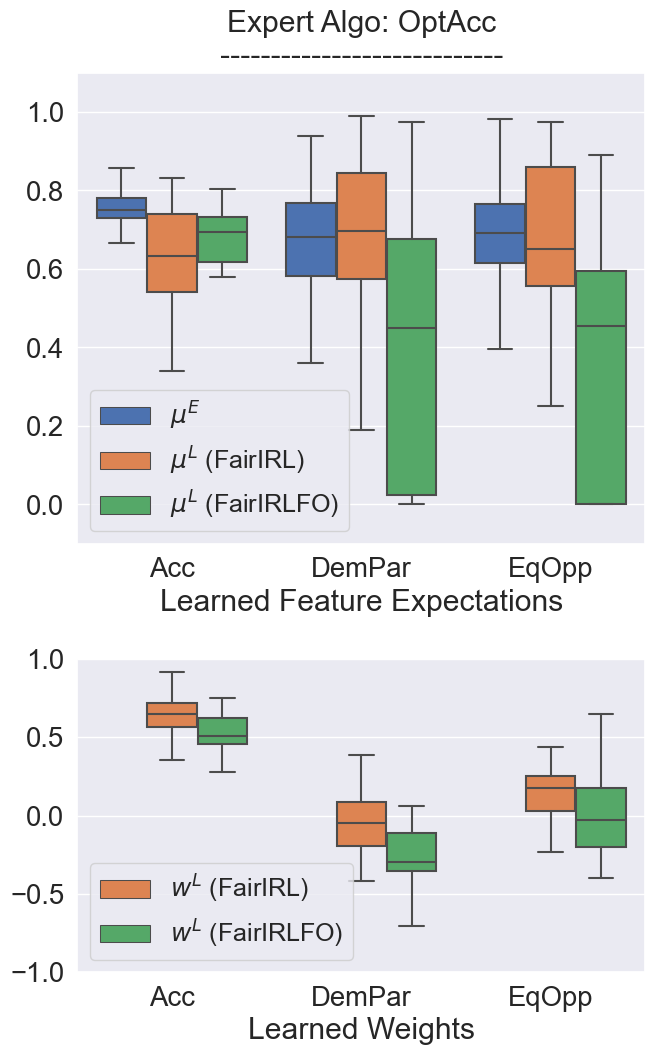

In [164]:
n_expert_demos = 3
n_init_pols = 1

mu_df, w_df = compare_results_source_domain_only(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='OptAcc',
    dataset='Boston',
    mu_noise_factor=.01,
    w_noise_factor=.01,
    mu_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
    extra_skip_conditions=(lambda info: (info['N_EXPERT_DEMOS'] != n_expert_demos) or (info['N_INIT_POLICIES'] != n_init_pols)),
#     extra_title=f"Expert Demos: {n_expert_demos}"
)

DATASET: Boston


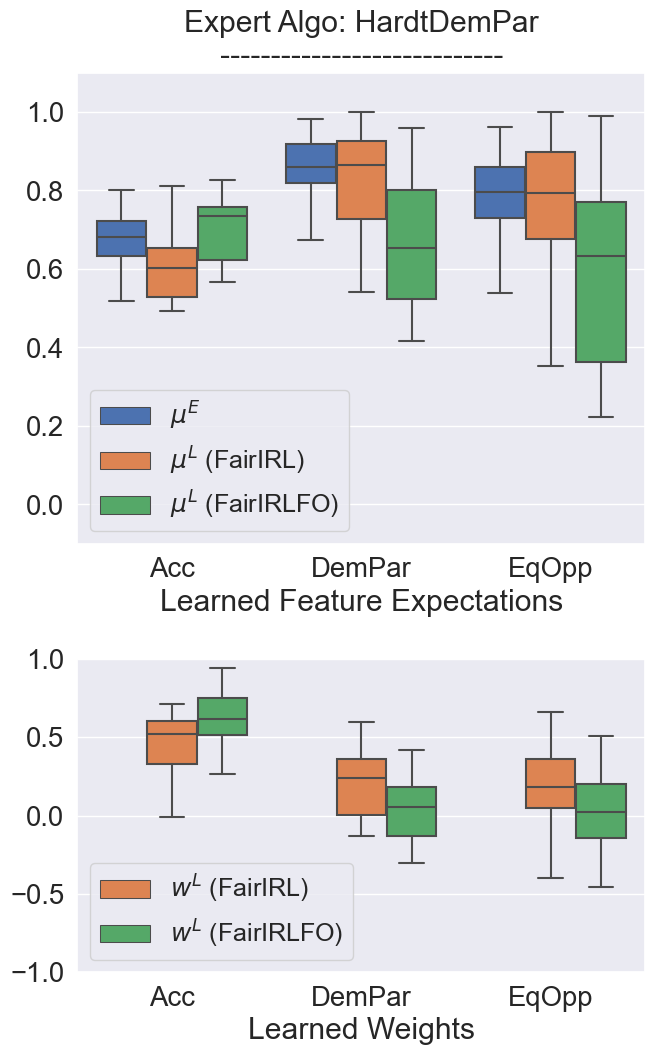

In [165]:
n_expert_demos = 3
n_init_pols = 1

mu_df, w_df = compare_results_source_domain_only(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='HardtDemPar',
    dataset='Boston',
    mu_noise_factor=.01,
    w_noise_factor=.01,
    mu_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
    extra_skip_conditions=(lambda info: (info['N_EXPERT_DEMOS'] != n_expert_demos) or (info['N_INIT_POLICIES'] != n_init_pols)),
#     extra_title=f"Expert Demos: {n_expert_demos}"
)

DATASET: Boston


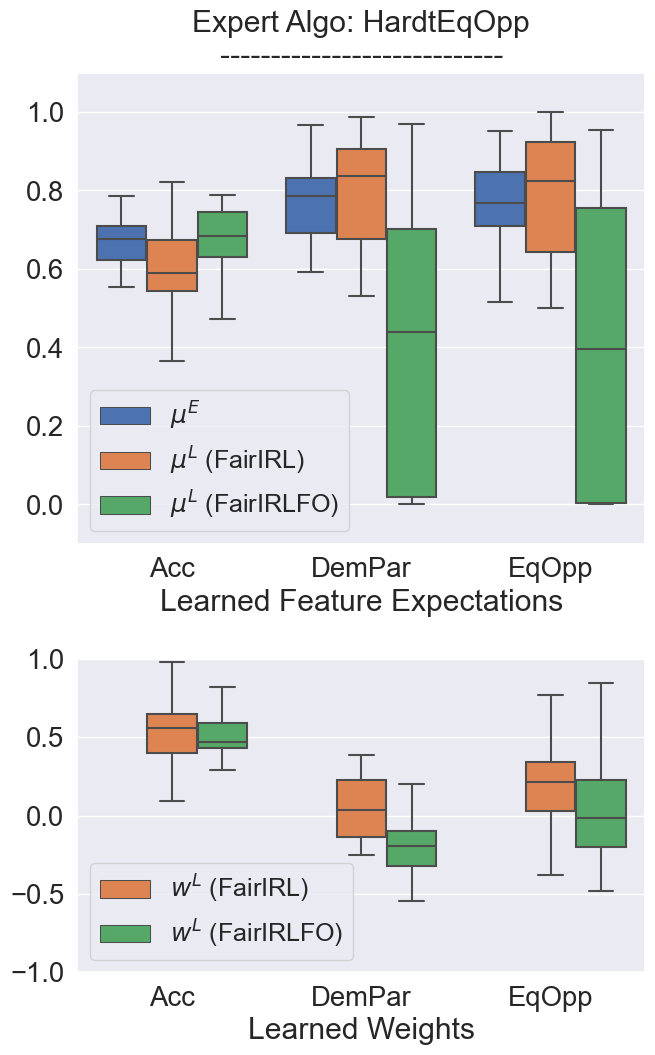

In [166]:
n_expert_demos = 3
n_init_pols = 1

mu_df, w_df = compare_results_source_domain_only(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='HardtEqOpp',
    dataset='Boston',
    mu_noise_factor=.01,
    w_noise_factor=.01,
    mu_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
    extra_skip_conditions=(lambda info: (info['N_EXPERT_DEMOS'] != n_expert_demos) or (info['N_INIT_POLICIES'] != n_init_pols)),
#     extra_title=f"Expert Demos: {n_expert_demos}"
)

# Compare results with target domain

In [177]:
sns.set_theme(font_scale=1.2)

def compare_results_with_target_domain(
    objective_set_names, expert_algo, source_dataset, target_dataset, 
    mu_noise_factor=0,
    w_noise_factor=0,
    mu_hue_order=[
        'muE',
        'muL (FairIRL)',
        'muL (FairIRLFO)',
        'muE_target',
        'muL_target',
    ],
    w_hue_order=[
        None,
        'wL (FairIRL)',
        'wL (FairIRLFO)',
#         'wL (FairIRLNorm)',
#         'wL (FairIRLNorm2)'
    ],
    irl_methods_to_exclude=['FairIRLDeNormed', 'FairIRLFODeNormed', 'FairIRLNorm2'],
):
    # Construct a pivot table so we can do a seaborn boxplot
    mu_cols = ['Value', 'Demo Producer', 'Feature Expectation']
    mu_rows = []
    w_cols = ['Value', 'IRL Method', 'Weight']
    w_rows = []

    path_prefix = './../../data/experiment_output/fair_irl/'
    trial_results_files = sorted(os.listdir(f"{path_prefix}/trial_results/"))
    trial_info_files = sorted(os.listdir(f"{path_prefix}/trial_info/"))

    # For each experiment...
    for (result_file, info_file) in zip(trial_results_files, trial_info_files):
        if result_file.replace('csv', '') != info_file.replace('json', ''):
            raise ValueError(
                f"Mismatched number of results and info files. "
                f"{result_file}, {info_file}"
            )
        result = pd.read_csv(f"{path_prefix}/trial_results/{result_file}", index_col=None)
        info = json.load(open(f"{path_prefix}/trial_info/{info_file}"))

        # Filter to only experiments for the input `expert_algo`
        if (
            info['EXPERT_ALGO'] != expert_algo
            or info['DATASET'] != source_dataset
            or info['TARGET_DATASET'] != target_dataset
            or set(info['OBJECTIVE_NAMES']) != set(objective_set_names)
            or info['IRL_METHOD'] in irl_methods_to_exclude
        ):
            continue
        
        for idx, row in result.iterrows():
            # Append muE and muL results
            for obj_name in info['OBJECTIVE_NAMES']:
                mu_rows.append([row[f"muE_hold_{obj_name}_mean"], 'muE', obj_name])
                if f"muE_target_{obj_name}" in row:
                    mu_rows.append([row[f"muE_target_{obj_name}"], 'muE_target', obj_name])
                    mu_rows.append([row[f"muL_target_hold_{obj_name}"], 'muL_target' + ' ' + info['IRL_METHOD'], obj_name])
            for obj_name in info['OBJECTIVE_NAMES']:
                mu_rows.append([row[f"muL_best_hold_{obj_name}"], f"muL ({info['IRL_METHOD']})", obj_name])
                w_rows.append([row[f"wL_{obj_name}"], f"wL ({info['IRL_METHOD']})", obj_name])

    if len(mu_rows) == 0:
        raise ValueError(f"No experimets with EXPERT_ALGO={expert_algo}")

    mu_df = pd.DataFrame(mu_rows, columns=mu_cols)
    mu_df['Value'] += mu_noise_factor*(np.random.rand(len(mu_df)) - .5)
    mu_df['Value'] = mu_df['Value'].clip(0, 1)
    mu_df = mu_df[
        mu_df['Demo Producer'].str.contains('muE')
        | mu_df['Demo Producer'].str.contains('muL_target')
    ]
    
    
    w_df = pd.DataFrame(w_rows, columns=w_cols)
    w_df['Value'] += w_noise_factor*(np.random.rand(len(w_df)) - .5)
    mu_df['Demo Producer'] = mu_df['Demo Producer'].str.replace('muE_target', r'$\\mu^E_{TARGET}$')
    mu_df['Demo Producer'] = mu_df['Demo Producer'].str.replace('muE', r'$\\mu^E_{SOURCE}$')
    mu_df['Demo Producer'] = mu_df['Demo Producer'].str.replace('muL_target', r'$\\mu^L_{TARGET}$')
    mu_df['Demo Producer'] = mu_df['Demo Producer'].str.replace('muL', r'$\\mu^L$')
    mu_hue_order = pd.Series(mu_hue_order).str.replace('muE_target', r'$\\mu^E_{TARGET}$')
    mu_hue_order = pd.Series(mu_hue_order).str.replace('muE', r'$\\mu^E_{SOURCE}$')
    mu_hue_order = pd.Series(mu_hue_order).str.replace('muL_target', r'$\\mu^L_{TARGET}$')
    mu_hue_order = pd.Series(mu_hue_order).str.replace('muL', r'$\\mu^L$')
    w_df['IRL Method'] = w_df['IRL Method'].str.replace('wL', r'$w^L$')
    w_hue_order = pd.Series(w_hue_order).str.replace('wL', r'$w^L$')
    
    mu_df = mu_df.sort_values(['Demo Producer', 'Feature Expectation'])
    w_df = w_df.sort_values(['Weight', 'IRL Method'])

    # Plot boxplot for feature expectations
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8.5), height_ratios=[2,1.33])
    sns.boxplot(
        x=mu_df['Feature Expectation'],
        y=mu_df['Value'],
        hue=mu_df['Demo Producer'],
#         hue_order=mu_hue_order,
        ax=ax1,
        fliersize=0,  # Remove outliers
        saturation=1,
        palette=list([cp[0]]) + list(cp[3:6]) + list(cp[7:]),
        boxprops=dict(alpha=1),
        linewidth=1,
    )
    ax1.set_ylabel(None)
    ax1.set_xlabel('Learned Feature Expectations')
    ax1.set_ylim([-.1,1.1])
    ax1.get_legend().remove()
#     ax1.legend(
#         title=None,
#         ncol=5,
# #         fontsize=12,
# #         loc='lower center',
#         bbox_to_anchor=(1.0, -.25),
#     )

    # Plot boxplot for weights
    sns.boxplot(
        x=w_df['Weight'],
        y=w_df['Value'],
        hue=w_df['IRL Method'],
#         hue_order=w_hue_order,
        ax=ax2,
        fliersize=0,  # Remove outliers
        saturation=1,
        boxprops=dict(alpha=1),
        linewidth=1,
        palette=list(cp[1:3]) + list(cp[6:]),
    )
    ax2.set_ylabel(None)
    ax2.set_xlabel('Learned Weights')
    ax2.set_ylim([-1.5, 1])
    ax2.get_legend().remove()
#     ax2.legend(
#         title=None,
#         ncol=3,
# #         fontsize=19.5,
# #         loc='lower center',
#         bbox_to_anchor=(.85, -.35),
#     )

    ax1.set_title(f"Expert Algo: {expert_algo}\n{28*'-'}")
    plt.tight_layout()
    
    print(f"SOURCE DATASET: {source_dataset}")
    print(f"TARGET DATASET: {target_dataset}")

    return mu_df, w_df

SOURCE DATASET: Boston
TARGET DATASET: COMPAS


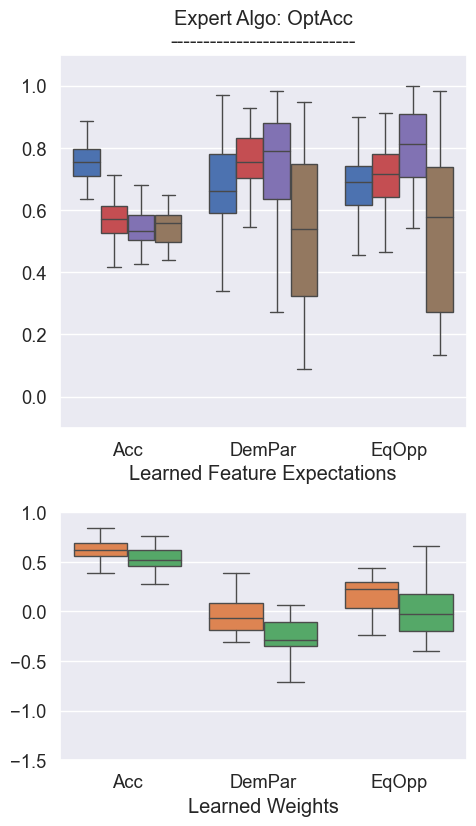

In [178]:
mu_df, w_df = compare_results_with_target_domain(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='OptAcc',
    source_dataset='Boston',
    target_dataset='COMPAS',
    mu_noise_factor=.1,
    w_noise_factor=.01,
)

SOURCE DATASET: Boston
TARGET DATASET: COMPAS


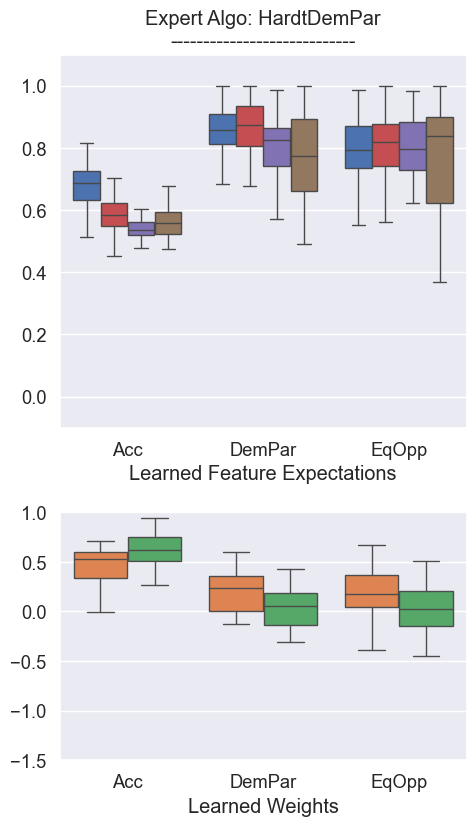

In [180]:
mu_df, w_df = compare_results_with_target_domain(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='HardtDemPar',
    source_dataset='Boston',
    target_dataset='COMPAS',
    mu_noise_factor=.1,
    w_noise_factor=.01,
)

SOURCE DATASET: Boston
TARGET DATASET: COMPAS


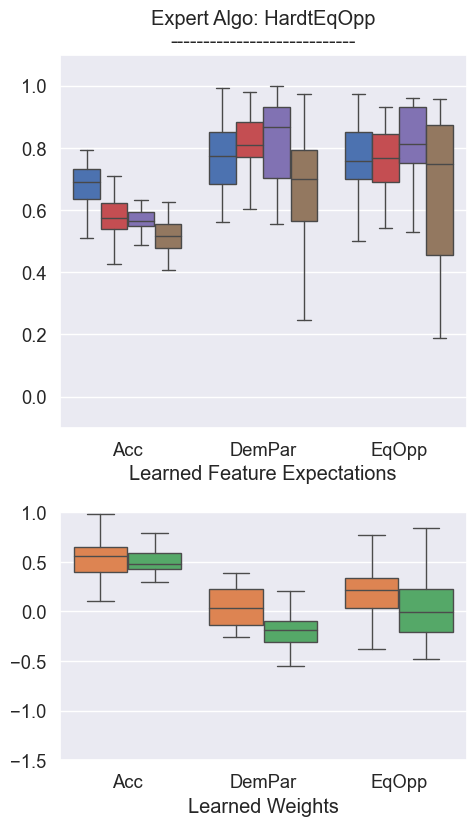

In [181]:
mu_df, w_df = compare_results_with_target_domain(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='HardtEqOpp',
    source_dataset='Boston',
    target_dataset='COMPAS',
    mu_noise_factor=.1,
    w_noise_factor=.01,
)

In [ ]:
from dataclasses import dataclass
from enum import Enum  
from typing import List  


class ScrapCode(Enum):  
    pass


@dataclass
class Scrap:  
    code: ScrapCode  
    weight: int  
    

@dataclass
class ScrapPile:  
    __components: List[Scrap]
    __history: List[int]
    identifier: str
    is_open: bool  

    @property
    def current_total(self) -> int:
        pass

    @property
    def history(self) -> List[int]:
        pass

    def get_weight(code: ScrapCode) -> int:
        pass
        
    def add_scrap(self, scrap: Scrap) -> None:  
        pass  
    
    def remove_scrap(
        self, weight: int, truck: Truck
        ) -> None:  
        pass

    def close(self) -> None:
        pass

# Scratch

In [346]:
from fairlearn.datasets import fetch_acs_income, fetch_bank_marketing, fetch_boston, fetch_diabetes_hospital

acs_inc = fetch_acs_income(as_frame=True)

# bank_mark = fetch_bank_marketing(as_frame=True)

# boston = fetch_boston(as_frame=True)

# diab_hosp = fetch_diabetes_hospital()

In [ ]:
fetch_boston()

In [349]:
bos_df = boston.data.copy()

In [356]:
bos_df['LSTAT_binary'] = bos_df['LSTAT'] >= bos_df['LSTAT'].median()
bos_df['y'] = bos_df['MEDV'] >= bos_df['MEDV'].median()

KeyError: 'MEDV'

In [354]:
# Observations below this point correspond to the "true" proportion of Black
# people above 63%, at which point the authors assumed that house prices would
# begin to be affected by the racism of others in the community.
bos_df['z'] = bos_df['B'] >= 136.9

In [357]:
bos_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y,z,LSTAT_binary
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,False,True,False
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,False,True,False
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,False,True,False
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,False,True,False
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,False,True,False
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,False,True,False
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,False,True,False
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,False,True,False


In [8]:
bos_df

NameError: name 'bos_df' is not defined

In [ ]:
flicker

In [ ]:
Ocala121